<a href="https://colab.research.google.com/github/ahsanrazi/LangChain/blob/main/08_RAG_APP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrieval Augmented Generation (RAG) App

In [1]:
from google.colab import userdata
gemini_api_key = userdata.get('GEMINI_API_KEY').strip()

In [2]:
!pip install -qU langgraph
!pip install -qU langchain-text-splitters
!pip install -qU langchain-community
!pip install -qU langchain-google-genai
!pip install -qU langchain-pinecone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.7/412.7 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.3/427.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 3.6 MB/s eta 0:00:00


In [3]:
# One of the most powerful applications enabled by LLMs is sophisticated question-answering (Q&A) chatbots.
# These are applications that can answer questions about specific source information.
# These applications use a technique known as Retrieval Augmented Generation, or RAG.

# Overview

In [4]:
# A typical RAG application has two main components

# A typical RAG application has two main components:
# Indexing: a pipeline for ingesting data from a source and indexing it. This usually happens offline.
# Retrieval and generation: The actual RAG chain, which takes the user query at run time and retrieves the relevant data from the index,
# then passes that to the model.

# Indexing

In [5]:
# Load: First we need to load our data. This is done with Document Loaders.

# Split: Text splitters break large Documents into smaller chunks. This is useful both for indexing data and passing it into a model,
# as large chunks are harder to search over and won't fit in a model's finite context window.

# Embed-Store: We need somewhere to store and index our splits, so that they can be searched over later.
# This is often done using a VectorStore and Embeddings model.

# Retrieval and generation

In [6]:
# Retrieve: Given a user input, relevant splits are retrieved from storage using a Retriever.
# Generate: A ChatModel / LLM produces an answer using a prompt that includes both the question with the retrieved data.

# Chat Model

In [28]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model = "gemini-2.0-flash-exp", api_key=gemini_api_key)

# Embedding Model

In [8]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key = gemini_api_key)

# Vectore Store

In [9]:
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone

index_name = "langchain"
namespace = "RAG"

pc = Pinecone(api_key= userdata.get('PINECONE_API'))
index = pc.Index(index_name)

vector_store = PineconeVectorStore(embedding=embeddings, index=index, namespace=namespace)

# 1. Indexing

### Loading documents

In [10]:
# We need to first load the blog post contents. We can use DocumentLoaders for this, which are objects
# that load in data from a source and return a list of Document objects.

# In this case we’ll use the WebBaseLoader, which uses urllib to load HTML from web URLs and BeautifulSoup to parse it to text.

In [11]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",), bs_kwargs={"parse_only": bs4_strainer})
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43130


In [12]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


### Splitting documents

In [13]:
# Our loaded document is over 42k characters which is too long to fit into the context window of many models.
# Even for those models that could fit the full post in their context window, models can struggle to find information in very long inputs.

# To handle this we’ll split the Document into chunks for embedding and vector storage.
# This should help us retrieve only the most relevant parts of the blog post at run time.


from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

In [14]:
print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


### Storing documents

In [15]:
# Now we need to index our 66 text chunks so that we can search over them at runtime.

document_ids = vector_store.add_documents(documents=all_splits)

In [16]:
print(document_ids[:3])

['066eb41d-db91-40b3-8ccb-e7f175c4c1f8', '1c813cc2-679b-4d91-b760-514302575a8c', '1b11d3a8-ac8f-4ffd-b46b-5b5444bd77ee']


# 2. Retrieval and Generation

In [19]:
# Now let’s write the actual application logic. We want to create a simple application that takes a user question, searches for documents
# relevant to that question, passes the retrieved documents and initial question to a model, and returns an answer.

# For generation, we will use the chat model
# We’ll use a prompt for RAG

from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke({"context": "(context goes here)", "question": "(question goes here)"}).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [20]:
# We'll use LangGraph to tie together the retrieval and generation steps into a single application.

# This will bring a number of benefits:
# We can define our application logic once and automatically support multiple invocation modes, including streaming, async, and batched calls.
# We can easily add key features to our application, including persistence and human-in-the-loop approval, with minimal code changes.

In [21]:
# To use LangGraph, we need to define three things:

# The state of our application;
# The nodes of our application (i.e., application steps);
# The "control flow" of our application (e.g., the ordering of the steps).

### State

In [22]:
# The state of our application controls what data is input to the application, transferred between steps, and output by the application.
# It is typically a TypedDict, but can also be a Pydantic BaseModel.

# For a simple RAG application, we can just keep track of the input question, retrieved context, and generated answer:

from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

### Nodes (application steps)

In [23]:
# Let's start with a simple sequence of two steps: retrieval and generation

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

### Control flow

In [24]:
# we compile our application into a single graph object. In this case, we are just connecting the retrieval and generation steps into a single sequence.

from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])

graph_builder.add_edge(START, "retrieve")

graph = graph_builder.compile()

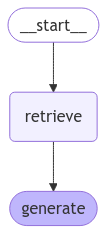

In [25]:
# LangGraph also comes with built-in utilities for visualizing the control flow of your application:

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Usage

In [30]:
# Invoke:

result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='1b11d3a8-ac8f-4ffd-b46b-5b5444bd77ee', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585.0}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='7111d4a4-51bd-49c9-96a7-a72b14f5b784', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192.0}, page_content='Tree of Thoughts (Yao et al. 2023) extends C

In [31]:
# Stream steps:

for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='1b11d3a8-ac8f-4ffd-b46b-5b5444bd77ee', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585.0}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='7111d4a4-51bd-49c9-96a7-a72b14f5b784', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192.0}, page_content='Tree of Thoughts (Yao et al.

### Customizing the prompt

In [33]:
# Above, we can load prompts (e.g., this RAG prompt) from the prompt hub. The prompt can also be easily customized.

from langchain_core.prompts import PromptTemplate

template = """
Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:
"""
custom_rag_prompt = PromptTemplate.from_template(template)

# Part-2

In [ ]:
# In many Q&A applications we want to allow the user to have a back-and-forth conversation, meaning the application needs
# some sort of "memory" of past questions and answers, and some logic for incorporating those into its current thinking.

# Here we focus on adding logic for incorporating historical messages. This involves the management of a chat history.

In [ ]:
# We will cover two approaches:

# Chains, in which we execute at most one retrieval step.
# Agents, in which we give an LLM discretion to execute multiple retrieval steps.

# Chains

In [34]:
# In the Part-1  we represented the user input, retrieved context, and generated answer as separate keys in the state.
# Conversational experiences can be naturally represented using a sequence of messages.
# Addition to messages from the user and assistant retrieved documents and other artifacts can be incorporated into a message sequence via tool messages.

# This motivates us to represent the state of our RAG application using a sequence of messages.

# Specifically, we will have

# User input as a HumanMessage;
# Vector store query as an AIMessage with tool calls;
# Retrieved documents as a ToolMessage;
# Final response as a AIMessage.

In [35]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [36]:
# Leveraging tool-calling to interact with a retrieval step has another benefit, which is that the query for the retrieval is generated by our model.
# This is especially important in a conversational setting, where user queries may require contextualization based on the chat history.
# As in the query analysis section of the RAG tutorial, this allows a model to rewrite user queries into more effective search queries.
# It also provides support for direct responses that do not involve a retrieval step.

from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join((f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")for doc in retrieved_docs)
    return serialized, retrieved_docs

In [ ]:
# Our graph will consist of three nodes:

# A node that fields the user input, either generating a query for the retriever or responding directly;
# A node for the retriever tool that executes the retrieval step;
# A node that generates the final response using the retrieved context.

In [37]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)

    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [38]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

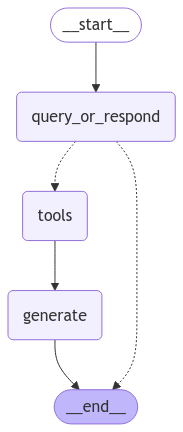

In [39]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
input_message = "Hello"

for step in graph.stream({"messages": [{"role": "user", "content": input_message}]},stream_mode="values",):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I help you today?


In [41]:
input_message = "What is Task Decomposition?"

for step in graph.stream({"messages": [{"role": "user", "content": input_message}]},stream_mode="values",):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (0f8834d6-8224-4668-9d04-65040185e16c)
 Call ID: 0f8834d6-8224-4668-9d04-65040185e16c
  Args:
    query: What is Task Decomposition?
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585.0}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks in

In [42]:
# In production, the Q&A application will usually persist the chat history into a database, and be able to read and update it appropriately.

# LangGraph implements a built-in persistence layer, making it ideal for chat applications that support multiple conversational turns.

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [43]:
input_message = "What is Task Decomposition?"

for step in graph.stream({"messages": [{"role": "user", "content": input_message}]},stream_mode="values",config=config,):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (0658fa67-6f85-4f7d-b50c-387c8c3335b1)
 Call ID: 0658fa67-6f85-4f7d-b50c-387c8c3335b1
  Args:
    query: What is Task Decomposition?
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585.0}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks in

In [44]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream({"messages": [{"role": "user", "content": input_message}]},stream_mode="values",config=config,):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (f4e7a5cf-ba47-4c84-8451-5a8d6871e399)
 Call ID: f4e7a5cf-ba47-4c84-8451-5a8d6871e399
  Args:
    query: common ways to do task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192.0}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done

# Agents

In [45]:
# Agents leverage the reasoning capabilities of LLMs to make decisions during execution.
# Using agents allows you to offload additional discretion over the retrieval process.
# Although their behavior is less predictable than the above "chain", they are able to execute multiple retrieval steps in service of a query,
# or iterate on a single search.

from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

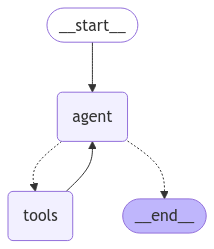

In [46]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [47]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream({"messages": [{"role": "user", "content": input_message}]},stream_mode="values",config=config,):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (bde3baa2-4e08-4714-8836-2c0f7796a59b)
 Call ID: bde3baa2-4e08-4714-8836-2c0f7796a59b
  Args:
    query: standard method for Task Decomposition
  retrieve (30e74f07-adfc-4ba3-af55-e25969d51e3f)
 Call ID: 30e74f07-adfc-4ba3-af55-e25969d51e3f
  Args:
    query: common extensions of Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192.0}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple 